In [ ]:
!wget "https://i.imgur.com/Bvro0YD.png"


!mkdir data
!mkdir data/Elephant

!mv Bvro0YD.png data/Elephant/Bvro0YD.png

--2022-05-27 20:26:17--  https://i.imgur.com/Bvro0YD.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4217496 (4.0M) [image/png]
Saving to: ‘Bvro0YD.png’

Bvro0YD.png         100%[===================>]   4.02M  --.-KB/s    in 0.08s   

2022-05-27 20:26:17 (49.5 MB/s) - ‘Bvro0YD.png’ saved [4217496/4217496]



In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print(pred[:,386]) #Corresponding to elephant

tensor([20.3945], grad_fn=<SelectBackward0>)


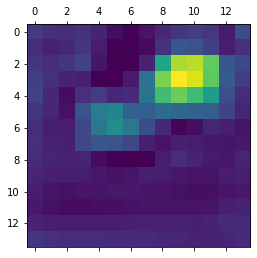

In [ ]:
# get the gradient of the output with respect to the parameters of the model
pred[:,386].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
import cv2
img = cv2.imread('./data/Elephant/Bvro0YD.png')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)



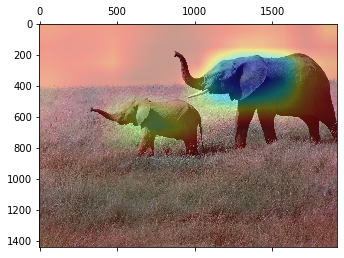

In [ ]:
superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
# cv2.imwrite('./map.jpg', superimposed_img)
plt.matshow(superimposed_img)